In [1]:
!pip install -q peft transformers bitsandbytes datasets

In [2]:
from datasets import load_dataset

dataset = load_dataset("flaviagiammarino/path-vqa", split='train[:4000]')

In [3]:
dataset['question'][0]

'where are liver stem cells (oval cells) located?'

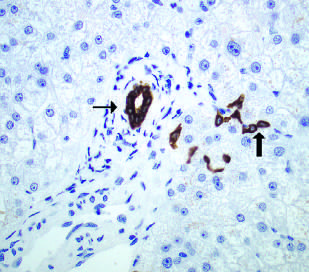

In [4]:
dataset[0]['image'].convert('RGB')

In [5]:
def create_text(example):
    example['text'] = 'Question: ' + example['question'] + ' Answer: ' + example['answer']
    example['image'] = (example['image'].resize((224, 224))).convert('RGB')
    return example

dataset = dataset.map(create_text)

In [6]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding

def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch

In [7]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", device_map="auto", load_in_8bit=True)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [8]:
from peft import LoraConfig, get_peft_model

# Let's define the LoraConfig
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 5,242,880 || all params: 3,749,922,816 || trainable%: 0.13981301102065136


In [9]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8, collate_fn=collate_fn)

In [10]:
import torch

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

device = "cuda" if torch.cuda.is_available() else "cpu"

model.train()
train_losses = []

for epoch in range(10):
  print("============================Epoch:", epoch,"=================================")
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device, torch.float16)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss

    print("Loss:", loss.item())
    
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
  train_losses.append(loss)

============================Epoch: 0 =================================
Loss: 6.90234375
Loss: 6.37890625
Loss: 5.6328125
Loss: 5.390625
Loss: 4.78125
Loss: 4.5859375
Loss: 4.28515625
Loss: 4.04296875
Loss: 4.22265625
Loss: 3.728515625
Loss: 3.640625
Loss: 3.736328125
Loss: 3.373046875
Loss: 2.87890625
Loss: 3.041015625
Loss: 2.7578125
Loss: 2.67578125
Loss: 2.498046875
Loss: 2.857421875
Loss: 2.392578125
Loss: 2.328125
Loss: 2.32421875
Loss: 2.09765625
Loss: 2.1015625
Loss: 2.220703125
Loss: 2.1953125
Loss: 1.8603515625
Loss: 1.7138671875
Loss: 1.962890625
Loss: 1.8154296875
Loss: 1.7294921875
Loss: 2.845703125
Loss: 1.9169921875
Loss: 2.17578125
Loss: 2.30859375
Loss: 2.08984375
Loss: 2.1796875
Loss: 2.19140625
Loss: 2.078125
Loss: 2.234375
Loss: 1.8681640625
Loss: 1.556640625
Loss: 2.236328125
Loss: 1.751953125
Loss: 1.8662109375
Loss: 1.796875
Loss: 1.6357421875
Loss: 2.140625
Loss: 1.5908203125
Loss: 1.4638671875
Loss: 1.4462890625
Loss: 1.5576171875
Loss: 1.5166015625
Loss: 1.5019

In [16]:
train_losses = [tensor.cpu().detach().numpy() for tensor in train_losses]

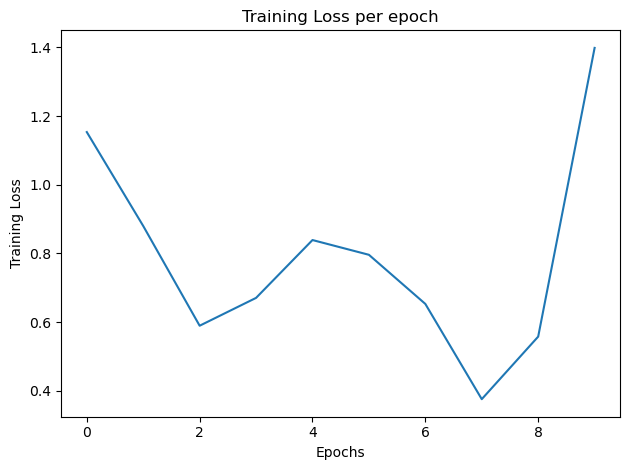

In [17]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1)

# First subplot
axs.plot(train_losses)
axs.set_xlabel('Epochs')
axs.set_ylabel('Training Loss')
axs.set_title('Training Loss per epoch')

# Display the figure
plt.tight_layout()
plt.show()

In [18]:
val_dataset = load_dataset("flaviagiammarino/path-vqa", split='validation[:100]')

In [19]:
inputs = processor(images=val_dataset[0]['image'].convert('RGB'), return_tensors="pt").to(device, torch.float16)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=25)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

Question: what is present? Answer: hematologic


In [21]:
val_dataset[0]['answer']

'neutrophils'

In [26]:
for i in range(1, 10):
    image = val_dataset[i]['image'].convert('RGB')
    question = val_dataset[i]['question']

    prompt = f"Question: {question} Answer:" 

    inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(**inputs, max_new_tokens=10)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    print("Question:", question)
    print("Generated Answer:", generated_text)
    print("Answer:", val_dataset[i]['answer'])
    print("------------------------------------")

Question: whose nuclei have been lost?
Generated Answer: the majority of the nuclei of the cell in
Answer: neutrophils
------------------------------------
Question: are two small pulmonary arterioles packed with laminated swirls of fetal squamous cells?
Generated Answer: no
Answer: yes
------------------------------------
Question: what is acute viral hepatitis characterized by?
Generated Answer: the presence of a large number of cystic-
Answer: predominantly lymphocytic infiltrate
------------------------------------
Question: what do the cells have?
Generated Answer: a wavy, wavy, wavy pattern
Answer: wavy nuclei
------------------------------------
Question: do the cells have wavy nuclei?
Generated Answer: yes
Answer: yes
------------------------------------
Question: do individual myocardial fibres have wavy nuclei?
Generated Answer: no
Answer: no
------------------------------------
Question: where is this area in the body?
Generated Answer: liver
Answer: abdomen
----------------